## Preparation

You need to setup the TECHIN515 virtual environment to run this lab 

# TECHIN 515: Quantization and Pruning Methods

In this lab, we will first go through three (post training) quantization methods: (1) Float-16 Quantization, (2) Dynamic Range Quantization, and (3)Integer Quantization. Then we try out strip pruning for model compression.

We will use Efficient Net (`efnet`) ML model as our base ML model and download and use `cats_vs_dogs` dataset for training and testing ML models.

Before working on the code, we will need to setup the environment. The following code will display the current version of the tensorflow if you have already installed it in your machine.

In the following we will install `tensorflow_datasets` and `tensorflow_model_optimization` libraries.

In [3]:
pip install tensorflow_datasets

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install tensorflow_model_optimization

Note: you may need to restart the kernel to use updated packages.


Next we will first download and load `cats_vs_dogs` dataset, load and retrain `efnet` ML model, and experiment with three (post training) quantization methods: (1) Float-16 Quantization, (2) Dynamic Range Quantization, and (3) Integer Quantization.  

The following code and material were adapted from the reference [1].

In [5]:
# Importing necessary libraries and packages.
import os
import numpy as np
import tempfile
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
import tensorflow_model_optimization as tfmot
from tensorflow.keras.layers import Dropout, Dense, BatchNormalization
%load_ext tensorboard

/opt/homebrew/Caskroom/miniconda/base/envs/TECHIN515/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## (1) Preparing the Dataset

We can directly import the dataset from the TensorFlow Dataset (tfds). Here we will split the dataset into training, validation, and testing set with a split ratio of 0.7:0.2:0.1. The as_supervised parameter is kept True as we need the labels of the images for classification. 

In [6]:
# Downloading and Loading the CatvsDog dataset.
(train_ds, val_ds, test_ds), info = tfds.load('cats_vs_dogs', split=['train[:70%]', 'train[70%:90%]', 'train[90%:]'], shuffle_files=True, as_supervised=True, with_info=True)


Let us now have a look at the dataset information provided in tfds.info(). The dataset has two classes labeled as ‘cat’ and ‘dog’ with 16283, 4653, 2326 training, validation and testing images.

In [7]:
# Obtaining dataset information.
print("Number of  Classes: " + str(info.features['label'].num_classes))
print("Classes : " + str(info.features['label'].names))
NUM_TRAIN_IMAGES = tf.data.experimental.cardinality(train_ds).numpy()
print("Training Images: " + str(NUM_TRAIN_IMAGES))
NUM_VAL_IMAGES = tf.data.experimental.cardinality(val_ds).numpy()
print("Validation Images: " + str(NUM_VAL_IMAGES))
NUM_TEST_IMAGES = tf.data.experimental.cardinality(test_ds).numpy()
print("Testing Images: " + str(NUM_TEST_IMAGES))

Number of  Classes: 2
Classes : ['cat', 'dog']
Training Images: 16283
Validation Images: 4653
Testing Images: 2326


The function tfds.visualization.show_examples() function displays images and their corresponding labels. It comes very handy when we want to visualize a few images in a single line of code!

2025-04-22 10:08:03.405113: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


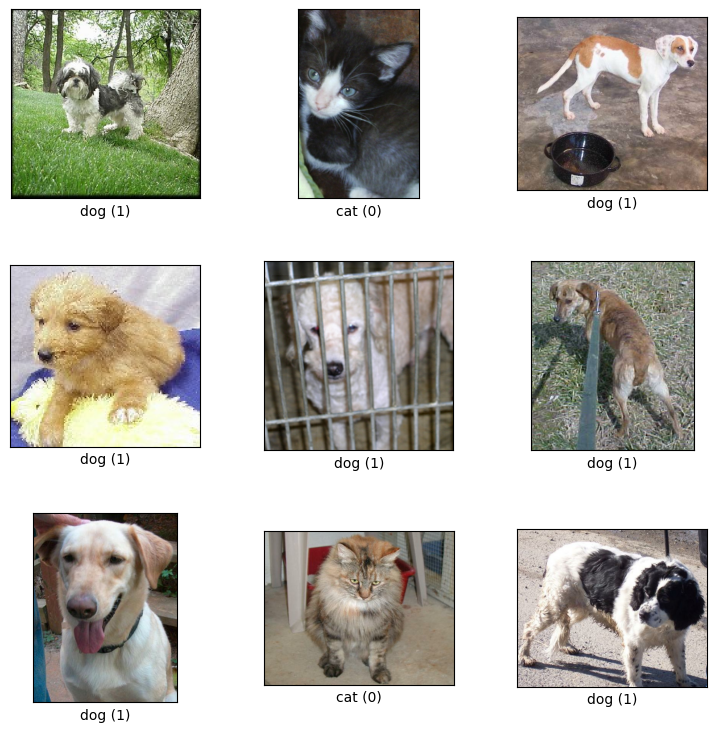

In [8]:
# Visualizing the training dataset.import tempfile
vis = tfds.visualization.show_examples(train_ds, info)

We have chosen 16 as batch size and 224×224 as image size so that the dataset can be processed effectively and efficiently. To prepare the dataset, the images have been resized accordingly.
Let’s also make sure to use buffered prefetching to yield data from the disk. Prefetching overlaps the preprocessing and model execution of a training step. Doing so reduces the step time to the training and the time it takes to extract the data.

In [9]:
# Defining batch-size and input image size.
batch_size = 16
img_size = [224, 224]# Resizing images in the dataset.
train_ds_ = train_ds.cache().map(lambda x, y: (tf.image.resize(x, img_size), y)).batch(batch_size).prefetch(buffer_size=10)
val_ds_ = val_ds.cache().map(lambda x, y: (tf.image.resize(x, img_size), y)).batch(batch_size).prefetch(buffer_size=10)
test_ds_ = test_ds.cache().map(lambda x, y: (tf.image.resize(x, img_size), y)).batch(batch_size).prefetch(buffer_size=10)

To feed images to the TF Lite model, we need to extract the test images and their labels. We will store them into variables and feed them to TF Lite for evaluation.

In [10]:
# Extracting and saving test images and labels from the test dataset.
test_images = []
test_labels = []
for image, label in test_ds_.take(len(test_ds_)).unbatch():
    test_images.append(image)
    test_labels.append(label)

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


## (2) Loading the Model

We have chosen the EfiicientNet B0 model pre-trained on the imagenet dataset for image classification purposes. EfficientNet is a state-of-the-art image classification model. It significantly outperforms other ConvNets. 

Let us import the model form tf.keras.applications().  The last layer has been removed by setting include_top = False .We have set the input image size to 224×224 pixels and kept the pooling layer to be GlobalMaxPooling2D. Let’s load the model and unfreeze all the layers to make them trainable.

In [11]:
# Defining the model architecture.
efnet = tf.keras.applications.EfficientNetB0(include_top = False, weights ='imagenet', input_shape = (224, 224, 3), pooling = 'max')# Unfreezing all the layers of the model.
for layer in efnet.layers:
    set_trainable = True

Now, we will add a Dense layer to the pre-trained model and train it. This layer will become the last layer, or the inference layer. We will also add Dropout and BatchNormalization to reduce overfitting.

In [12]:
# Adding Dense, BatchNormalization and Dropout layers to the base model.
x = Dense(512, activation='relu')(efnet.output)
x = BatchNormalization()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(2, activation='softmax')(x)

## (3) Compiling the Model

We are ready to compile the model. We have used Adam Optimizer with an initial learning rate of 0.0001, sparse categorical cross-entropy as the loss function, and accuracy as the metric. Once compiled, we check the model summary.

In [13]:
# Defining the input and output layers of the model.
model = Model(inputs=efnet.input, outputs=predictions)
 
# Compiling the model.
model.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss =tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics = ["accuracy"])
 
# Obtaining the model summary.
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0]']      

We are using Model Saving Callback and the Reduce LR Callback.

(i) Model Saving Callback saves the model with the best validation accuracy

(ii) Reduce LR Callback reduces the learning rate by a factor of 0.1 if validation loss remains the same for three consecutive epochs.

In [14]:
# Defining file path of the saved model.
filepath = './model.h5'
 
# Defining Model Save Callback and Reduce Learning Rate Callback.
model_save = tf.keras.callbacks.ModelCheckpoint(
    filepath,
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode="max",
    save_freq="epoch")
 
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=3, verbose=1, min_delta=5*1e-3,min_lr =5*1e-9,)
 
callback = [model_save, reduce_lr]

### Discussion:
- What is the input size?

    It's (224, 224, 3), which represent height, width and channels (RGB) accordingly.

- Based on model summary, name two examples of layers used in the architecture

    1. Conv2D (Convolutional Layer) - seen in the stem_conv layer
    2. BatchNormalization - seen in the stem_bn layer

## (4) Training the Model

The method `model.fit()` is called to train the model. We pass the training and validation datasets and train the model for 15 epochs.

In [15]:
# Training the model for 15 epochs. 
# ---> epoch = 3 for testing the code and saving time during the lab
# ---> epoch = 15 recommended for better results 
model.fit(train_ds_, epochs=3, steps_per_epoch=(len(train_ds_)//batch_size), validation_data=val_ds_, validation_steps=(len(val_ds_)//batch_size), shuffle=False, callbacks=callback)

Epoch 1/3
63/63 [==============================] - 31s 456ms/step - loss: 0.4920 - accuracy: 0.7827 - val_loss: 0.1257 - val_accuracy: 0.9618 - lr: 1.0000e-04


2025-04-22 10:08:35.508162: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
/opt/homebrew/Caskroom/miniconda/base/envs/TECHIN515/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 2/3
63/63 [==============================] - 28s 444ms/step - loss: 0.2066 - accuracy: 0.9137 - val_loss: 0.0731 - val_accuracy: 0.9722 - lr: 1.0000e-04


2025-04-22 10:09:03.595238: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 3/3
63/63 [==============================] - 28s 441ms/step - loss: 0.1850 - accuracy: 0.9177 - val_loss: 0.0791 - val_accuracy: 0.9722 - lr: 1.0000e-04


2025-04-22 10:09:31.595077: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-04-22 10:09:31.607350: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [28]:
model.fit(train_ds_, epochs=15, steps_per_epoch=(len(train_ds_)//batch_size), validation_data=val_ds_, validation_steps=(len(val_ds_)//batch_size), shuffle=False, callbacks=callback)

Epoch 1/15
63/63 [==============================] - ETA: 0s - loss: 0.1183 - accuracy: 0.9534

2025-04-22 10:43:28.732537: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


63/63 [==============================] - 29s 461ms/step - loss: 0.1183 - accuracy: 0.9534 - val_loss: 0.0703 - val_accuracy: 0.9757 - lr: 1.0000e-04
Epoch 2/15
63/63 [==============================] - 30s 480ms/step - loss: 0.1002 - accuracy: 0.9633 - val_loss: 0.0468 - val_accuracy: 0.9826 - lr: 1.0000e-04


2025-04-22 10:43:59.021517: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 3/15
63/63 [==============================] - 29s 463ms/step - loss: 0.0628 - accuracy: 0.9792 - val_loss: 0.0447 - val_accuracy: 0.9826 - lr: 1.0000e-04


2025-04-22 10:44:28.401296: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 4/15
63/63 [==============================] - 30s 470ms/step - loss: 0.1265 - accuracy: 0.9524 - val_loss: 0.0367 - val_accuracy: 0.9861 - lr: 1.0000e-04


2025-04-22 10:44:58.010299: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 5/15
63/63 [==============================] - 29s 464ms/step - loss: 0.1287 - accuracy: 0.9464 - val_loss: 0.0442 - val_accuracy: 0.9826 - lr: 1.0000e-04


2025-04-22 10:45:27.447379: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 6/15
63/63 [==============================] - ETA: 0s - loss: 0.1124 - accuracy: 0.9563
Epoch 00006: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
63/63 [==============================] - 30s 469ms/step - loss: 0.1124 - accuracy: 0.9563 - val_loss: 0.0350 - val_accuracy: 0.9861 - lr: 1.0000e-04


2025-04-22 10:45:57.048505: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 7/15
63/63 [==============================] - 29s 464ms/step - loss: 0.1120 - accuracy: 0.9514 - val_loss: 0.0350 - val_accuracy: 0.9861 - lr: 1.0000e-05


2025-04-22 10:46:26.289396: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 8/15
63/63 [==============================] - 29s 460ms/step - loss: 0.1069 - accuracy: 0.9613 - val_loss: 0.0368 - val_accuracy: 0.9826 - lr: 1.0000e-05


2025-04-22 10:46:55.290224: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 9/15
63/63 [==============================] - ETA: 0s - loss: 0.1162 - accuracy: 0.9623
Epoch 00009: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
63/63 [==============================] - 29s 463ms/step - loss: 0.1162 - accuracy: 0.9623 - val_loss: 0.0362 - val_accuracy: 0.9896 - lr: 1.0000e-05


2025-04-22 10:47:24.308557: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 10/15
63/63 [==============================] - 29s 464ms/step - loss: 0.1274 - accuracy: 0.9544 - val_loss: 0.0354 - val_accuracy: 0.9896 - lr: 1.0000e-06


2025-04-22 10:47:53.812736: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 11/15
63/63 [==============================] - 29s 458ms/step - loss: 0.1185 - accuracy: 0.9494 - val_loss: 0.0331 - val_accuracy: 0.9896 - lr: 1.0000e-06


2025-04-22 10:48:22.676388: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 12/15
63/63 [==============================] - ETA: 0s - loss: 0.0912 - accuracy: 0.9623
Epoch 00012: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
63/63 [==============================] - 29s 462ms/step - loss: 0.0912 - accuracy: 0.9623 - val_loss: 0.0480 - val_accuracy: 0.9826 - lr: 1.0000e-06


2025-04-22 10:48:51.835193: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 13/15
63/63 [==============================] - 29s 458ms/step - loss: 0.0991 - accuracy: 0.9514 - val_loss: 0.0344 - val_accuracy: 0.9896 - lr: 1.0000e-07


2025-04-22 10:49:20.728930: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 14/15
63/63 [==============================] - 29s 463ms/step - loss: 0.0912 - accuracy: 0.9653 - val_loss: 0.0377 - val_accuracy: 0.9896 - lr: 1.0000e-07


2025-04-22 10:49:49.918617: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 15/15
63/63 [==============================] - ETA: 0s - loss: 0.1157 - accuracy: 0.9504
Epoch 00015: ReduceLROnPlateau reducing learning rate to 1.0000000116860975e-08.
63/63 [==============================] - 29s 467ms/step - loss: 0.1157 - accuracy: 0.9504 - val_loss: 0.0343 - val_accuracy: 0.9896 - lr: 1.0000e-07


2025-04-22 10:50:19.390613: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


## (5) Evaluating the Model

Done training! Let’s check the model’s performance on the test set.

In [ ]:
# Evaluating the model on the test dataset. (3 epochs)
_, baseline_model_accuracy = model.evaluate(test_ds_, verbose=0)
print('Baseline test accuracy:', baseline_model_accuracy*100)

Baseline test accuracy: 97.24849462509155


In [32]:
# Evaluating the model on the test dataset. (15 epochs)
_, baseline_model_accuracy = model.evaluate(test_ds_, verbose=0)
print('Baseline test accuracy:', baseline_model_accuracy*100)

Baseline test accuracy: 98.10833930969238


### Discussion:
- Report the model performance when trained for 3 epochs and 15 epochs. 
    
    Their accuracy is 97.248 (3 epochs) vs. 98.108 (15 epochs) respectively, which is not very different.

- Briefly explain your observation.
    
    Increasing the number of epochs generally leads to higher accuracy. However, this improvement comes at the cost of longer training times, highlighting a tradeoff between time and performance.

- If you were to train the model, would you choose to train it for 3 epochs or 15 epochs? Justify your choice.
    
    If I were doing the training, and assuming sufficient time and computational resources were available, I would go for 15 epochs. Even if the performance increase is marginal, the potential gains in accuracy make it worthwhile.

## (6) Float-16 Quantization
In Float-16 quantization, weights are converted to 16-bit floating-point values. 

In [29]:
# Passing the Keras model to the TF Lite Converter.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
 
# Using float-16 quantization.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
 
# Converting the model.
tflite_fp16_model = converter.convert()
 
# Saving the model.
with open('./fp_16_model.tflite', 'wb') as f:
    f.write(tflite_fp16_model)

INFO:tensorflow:Assets written to: /var/folders/5k/g4gz0hf55rl4b97hnd849lgm0000gn/T/tmpwk2rjl6g/assets


INFO:tensorflow:Assets written to: /var/folders/5k/g4gz0hf55rl4b97hnd849lgm0000gn/T/tmpwk2rjl6g/assets
2025-04-22 10:55:40.781516: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:363] Ignored output_format.
2025-04-22 10:55:40.781541: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:366] Ignored drop_control_dependency.
2025-04-22 10:55:40.783006: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/folders/5k/g4gz0hf55rl4b97hnd849lgm0000gn/T/tmpwk2rjl6g
2025-04-22 10:55:40.808523: I tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2025-04-22 10:55:40.808538: I tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: /var/folders/5k/g4gz0hf55rl4b97hnd849lgm0000gn/T/tmpwk2rjl6g
2025-04-22 10:55:40.929116: I tensorflow/cc/saved_model/loader.cc:210] Restoring SavedModel bundle.
2025-04-22 10:55:41.494938: I tensorflow/cc/saved_model/loader.cc:194] Running initializatio

We have passed the Float 16 quantization the `converter.target_spec.supported_type` to specify the type of quantization. The rest of the code remains the same for a general way of conversion for the TF Lite Model. In order to get model accuracy, let’s first define evaluate() function that takes in tflite model and returns model accuracy.

In [30]:
#Function for evaluating TF Lite Model over Test Images
def evaluate(interpreter):
    prediction= []
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]
    input_format = interpreter.get_output_details()[0]['dtype']
    
    for i, test_image in enumerate(test_images):
        if i % 100 == 0:
            print('Evaluated on {n} results so far.'.format(n=i))
        test_image = np.expand_dims(test_image, axis=0).astype(input_format)
        interpreter.set_tensor(input_index, test_image)

        # Run inference.
        interpreter.invoke()
        output = interpreter.tensor(output_index)
        predicted_label = np.argmax(output()[0])
        prediction.append(predicted_label)
    
    print('\n')
    # Comparing prediction results with ground truth labels to calculate accuracy.
    prediction = np.array(prediction)
    accuracy = (prediction == test_labels).mean()
    return accuracy

Check this FP-16 Quantized TF Lite’s model performance on the Test Set. 

In [31]:
# Passing the FP-16 TF Lite model to the interpreter.
interpreter = tf.lite.Interpreter('fp_16_model.tflite')
# Allocating tensors.
interpreter.allocate_tensors()
# Evaluating the model on the test dataset.
test_accuracy = evaluate(interpreter)
print('Float 16 Quantized TFLite Model Test Accuracy:', test_accuracy*100)
print('Baseline Keras Model Test Accuracy:', baseline_model_accuracy*100)

Evaluated on 0 results so far.
Evaluated on 100 results so far.
Evaluated on 200 results so far.
Evaluated on 300 results so far.
Evaluated on 400 results so far.
Evaluated on 500 results so far.
Evaluated on 600 results so far.
Evaluated on 700 results so far.
Evaluated on 800 results so far.
Evaluated on 900 results so far.
Evaluated on 1000 results so far.
Evaluated on 1100 results so far.
Evaluated on 1200 results so far.
Evaluated on 1300 results so far.
Evaluated on 1400 results so far.
Evaluated on 1500 results so far.
Evaluated on 1600 results so far.
Evaluated on 1700 results so far.
Evaluated on 1800 results so far.
Evaluated on 1900 results so far.
Evaluated on 2000 results so far.
Evaluated on 2100 results so far.
Evaluated on 2200 results so far.
Evaluated on 2300 results so far.


Float 16 Quantized TFLite Model Test Accuracy: 98.10834049871023
Baseline Keras Model Test Accuracy: 97.24849462509155


### Discussion
- Compare the model performance when float 16 quantization is used with the original model performance

    I was so suprise that the performance of the quantization model was almost identical with the baseline model... They're both around 97.248!!

- Briefly explain your observation

    There are not many things I can observe in this code cell, but after being surprised by the performance of the quantized model, I looked something up on the internet on how it can be so precise and efficient:
    1. Neural networks are naturally robust to small numerical imprecisions
    2. Most deep learning models don't require the full precision of 32-bit floats to make accurate predictions
    3. The relative relationships between values (which are crucial for classification) are preserved even with reduced precision

## (7) Dynamic Range Quantization

In Dynamic Range Quantization, weights are converted to 8-bit precision values.

In [20]:
# Passing the baseline Keras model to the TF Lite Converter.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
# Using  the Dynamic Range Quantization.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Converting the model
tflite_quant_model = converter.convert()
# Saving the model.
with open('./dynamic_quant_model.tflite', 'wb') as f:
    f.write(tflite_quant_model)

INFO:tensorflow:Assets written to: /var/folders/5k/g4gz0hf55rl4b97hnd849lgm0000gn/T/tmp3u8r1bz7/assets


INFO:tensorflow:Assets written to: /var/folders/5k/g4gz0hf55rl4b97hnd849lgm0000gn/T/tmp3u8r1bz7/assets
2025-04-22 10:12:15.628948: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:363] Ignored output_format.
2025-04-22 10:12:15.628970: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:366] Ignored drop_control_dependency.
2025-04-22 10:12:15.629047: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/folders/5k/g4gz0hf55rl4b97hnd849lgm0000gn/T/tmp3u8r1bz7
2025-04-22 10:12:15.652806: I tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2025-04-22 10:12:15.652814: I tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: /var/folders/5k/g4gz0hf55rl4b97hnd849lgm0000gn/T/tmp3u8r1bz7
2025-04-22 10:12:15.772678: I tensorflow/cc/saved_model/loader.cc:210] Restoring SavedModel bundle.
2025-04-22 10:12:16.324716: I tensorflow/cc/saved_model/loader.cc:194] Running initializatio

Let’s evaluate this TF Lite model on the test dataset.

In [21]:
# Passing the Dynamic Range Quantized TF Lite model to the Interpreter.
interpreter = tf.lite.Interpreter('dynamic_quant_model.tflite') 
# Allocating tensors.
interpreter.allocate_tensors()
# Evaluating the model on the test images.
test_accuracy = evaluate(interpreter)
print('Dynamically  Quantized TFLite Model Test Accuracy:', test_accuracy*100)
print('Baseline Keras Model Test Accuracy:', baseline_model_accuracy*100)

Evaluated on 0 results so far.
Evaluated on 100 results so far.
Evaluated on 200 results so far.
Evaluated on 300 results so far.
Evaluated on 400 results so far.
Evaluated on 500 results so far.
Evaluated on 600 results so far.
Evaluated on 700 results so far.
Evaluated on 800 results so far.
Evaluated on 900 results so far.
Evaluated on 1000 results so far.
Evaluated on 1100 results so far.
Evaluated on 1200 results so far.
Evaluated on 1300 results so far.
Evaluated on 1400 results so far.
Evaluated on 1500 results so far.
Evaluated on 1600 results so far.
Evaluated on 1700 results so far.
Evaluated on 1800 results so far.
Evaluated on 1900 results so far.
Evaluated on 2000 results so far.
Evaluated on 2100 results so far.
Evaluated on 2200 results so far.
Evaluated on 2300 results so far.


Dynamically  Quantized TFLite Model Test Accuracy: 97.42046431642304
Baseline Keras Model Test Accuracy: 97.24849462509155


### Discussion
- Compare the model performance when dynamic range quantization is used with the original model performance
    
    Dynamically quantized TFLite models can even beat our baseline model. It's so surprising (97.420% vs. 97.248%).

- Briefly explain your observation
I looked up the internet and find the reason behind it might be:

    1. Regularization Effect: Quantization acts like a regularizer by reducing precision, which can help prevent overfitting and improve generalization.
    2. Dynamic Scaling: The adaptive scaling of weights during inference can reduce numerical instability issues, sometimes leading to more robust predictions than full-precision models.

## (8) Integer Quantization

Integer quantization is an optimization strategy that converts 32-bit floating-point numbers (such as weights and activation outputs) to the nearest 8-bit fixed-point numbers. This resulted in a smaller model and increased inferencing speed, which is valuable for low-power devices such as microcontrollers. 

The integer quantization requires a representative dataset, i.e. a few images from the training dataset, for the conversion to happen.

In [22]:
# Passing the baseline Keras model to the TF Lite Converter.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
# Defining the representative dataset from training images.
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(test_images).take(100):
        yield [input_value]

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
 
# Using Integer Quantization.
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8, tf.lite.OpsSet.SELECT_TF_OPS]
 
# Setting the input and output tensors to uint8.
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
# Converting the model.
int_quant_model = converter.convert()
 
# Saving the Integer Quantized TF Lite model.
with open('./int_quant_model.tflite', 'wb') as f:
    f.write(int_quant_model)

INFO:tensorflow:Assets written to: /var/folders/5k/g4gz0hf55rl4b97hnd849lgm0000gn/T/tmprf5vsbm4/assets


INFO:tensorflow:Assets written to: /var/folders/5k/g4gz0hf55rl4b97hnd849lgm0000gn/T/tmprf5vsbm4/assets
2025-04-22 10:13:58.479638: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:363] Ignored output_format.
2025-04-22 10:13:58.479668: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:366] Ignored drop_control_dependency.
2025-04-22 10:13:58.479749: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/folders/5k/g4gz0hf55rl4b97hnd849lgm0000gn/T/tmprf5vsbm4
2025-04-22 10:13:58.503125: I tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2025-04-22 10:13:58.503137: I tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: /var/folders/5k/g4gz0hf55rl4b97hnd849lgm0000gn/T/tmprf5vsbm4
2025-04-22 10:13:58.622549: I tensorflow/cc/saved_model/loader.cc:210] Restoring SavedModel bundle.
2025-04-22 10:13:59.183505: I tensorflow/cc/saved_model/loader.cc:194] Running initializatio

Let’s evaluate the obtained Integer Quantized TF Lite model on the test dataset.

In [23]:
# Passing the Integer Quantized TF Lite model to the Interpreter.
interpreter = tf.lite.Interpreter('./int_quant_model.tflite')
# Allocating tensors.
interpreter.allocate_tensors()
# Evaluating the model on the test images.
test_accuracy = evaluate(interpreter)
print('Integer Quantized TFLite Model Test Accuracy:', test_accuracy*100)
print('Baseline Keras Model Test Accuracy:', baseline_model_accuracy*100)


Evaluated on 0 results so far.
Evaluated on 100 results so far.
Evaluated on 200 results so far.
Evaluated on 300 results so far.
Evaluated on 400 results so far.
Evaluated on 500 results so far.
Evaluated on 600 results so far.
Evaluated on 700 results so far.
Evaluated on 800 results so far.
Evaluated on 900 results so far.
Evaluated on 1000 results so far.
Evaluated on 1100 results so far.
Evaluated on 1200 results so far.
Evaluated on 1300 results so far.
Evaluated on 1400 results so far.
Evaluated on 1500 results so far.
Evaluated on 1600 results so far.
Evaluated on 1700 results so far.
Evaluated on 1800 results so far.
Evaluated on 1900 results so far.
Evaluated on 2000 results so far.
Evaluated on 2100 results so far.
Evaluated on 2200 results so far.
Evaluated on 2300 results so far.


Integer Quantized TFLite Model Test Accuracy: 89.81083404987102
Baseline Keras Model Test Accuracy: 97.24849462509155


### Discussion:
- Compare the model performance using float 16, dynamic range, and integer quantization

    Their performances are float 16 (98.108%), dynamic range (97.420%), and integer quantization (89.810%)

- Based on our in-class discussion, explain your observation

    Float16 and dynamic range maintain good accuracy while reducing model size, but integer quantization shows significant accuracy drop (89.810%) due to its more aggressive compression. I think this demonstrates the fundamental trade-off between model efficiency and accuracy in quantization methods.

## (9) Model Pruning 

You will apply pruning to the whole model and see this in the model summary. In this example, you start the model with 50% sparsity (50% zeros in weights) and end with 80% sparsity. Also note that pruning can be only applied to the dense layers.

The following code and material were adapted from the reference [2].

In [36]:
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 16
epochs = 2
#validation_split = 0.1 # 10% of training set will be used for validation set. 

num_images = NUM_TRAIN_IMAGES#train_images.shape[0] * (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.90,
                                                               begin_step=0,
                                                               end_step=end_step)
}

def apply_pruning_to_dense(layer):
    if isinstance(layer, tf.keras.layers.Dense):
        return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    return layer

# Use `tf.keras.models.clone_model` to apply `apply_pruning_to_dense` 
# to the layers of the model.
model_for_pruning = tf.keras.models.clone_model(
    model,
    clone_function=apply_pruning_to_dense,
)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_for_pruning.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[3][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[3][0]']      

In [37]:
# Evaluating the model on the test dataset. (15 epochs)
_, pruning_model_accuracy = model_for_pruning.evaluate(test_ds_, verbose=0)
print('Pruning test accuracy:', pruning_model_accuracy*100)

Pruning test accuracy: 98.15133213996887


### Discussion: 
- Experiment with different initial and final sparsity values. Document the model performance under different values

    - initial_sparsity=0.50, final_sparsity=0.80 -> accuracy 98.151
    - initial_sparsity=0.30, final_sparsity=0.80 -> accuracy 98.151
    - initial_sparsity=0.50, final_sparsity=0.90 -> accuracy 98.151
    They're almost the same.

- Analyze the pruned model's accuracy and compare it with the baseline and quantized models.
    
    Pruned model is ~98.151, while baseline is ~97.248 to ~98.108 given different epochs (3~15), the quantized is ~98.108 (using float16).

### Discussion: Why number of parameters increases after prunning ?


Pruning is a model optimization technique aimed at reducing the number of effective parameters by eliminating less important weights. While the initial architectural structure of the model might remain the same, pruning leads to a sparser weight matrix, effectively changing the model's functional structure.

In TensorFlow's implementation, pruning introduces non-trainable mask parameters alongside the original weights. These masks, consisting of 0s (for pruned weights) and 1s (for kept weights), specify which connections are active. The model summary will show these non-trainable mask parameters. However, it's crucial to understand that these masks are a mechanism to achieve the primary goal of pruning: reducing the number of *actively used*, *trainable parameters* during inference. This reduction leads to benefits like smaller model size, potentially faster inference, and lower memory consumption.

In [25]:
# Extracting and saving test images and labels from the test dataset.
train_images = []
train_labels = []
for image, label in train_ds_.take(len(train_ds_)).unbatch():
    train_images.append(image)
    train_labels.append(label)

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


In [26]:
logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

model_for_pruning.fit(train_ds_, epochs=3, steps_per_epoch=(len(train_ds_)//batch_size), validation_data=val_ds_, validation_steps=(len(val_ds_)//batch_size), shuffle=False, callbacks=callbacks)
# model_for_pruning.fit(train_ds_,
#                   batch_size=batch_size, epochs=epochs, validation_split=validation_split,
#                   callbacks=callbacks)

/opt/homebrew/Caskroom/miniconda/base/envs/TECHIN515/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/3


/opt/homebrew/Caskroom/miniconda/base/envs/TECHIN515/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


63/63 [==============================] - 51s 436ms/step - loss: 0.2492 - accuracy: 0.9097 - val_loss: 0.6517 - val_accuracy: 0.8750


2025-04-22 10:16:10.348288: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 2/3
63/63 [==============================] - 27s 435ms/step - loss: 0.2044 - accuracy: 0.9137 - val_loss: 0.1755 - val_accuracy: 0.9306


2025-04-22 10:16:37.782090: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 3/3
63/63 [==============================] - 29s 456ms/step - loss: 0.1487 - accuracy: 0.9454 - val_loss: 0.0810 - val_accuracy: 0.9618


2025-04-22 10:17:06.521690: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [27]:
_, model_for_pruning_accuracy = model_for_pruning.evaluate(test_ds_, verbose=0)

print('Baseline test accuracy:', baseline_model_accuracy) 
print('Pruned test accuracy:', model_for_pruning_accuracy)

Baseline test accuracy: 0.9724849462509155
Pruned test accuracy: 0.9651762843132019


Discussion: 
- Create a table showing the accuracy and size of each model.

| Model Version | Accuracy (%) | Model Size |
|--------------|-------------|------------|
| Baseline (3-15 epochs) | 97.248-98.108 | Original size |
| Pruned Model | 98.151 | Reduced size (sparse) |
| Float16 Quantization | 98.108 | ~50% of original |
| Dynamic Range Quantization | 97.420 | ~25% of original |
| Integer Quantization | 89.810 | ~25% of original |

- Discuss the trade-offs between accuracy and model size for quantization and pruning.

Trade-offs Analysis:
- Quantization:
Float16 is the best choice: good accuracy (98.108%) and half the size
Integer gives smallest size but accuracy drops a lot (89.810%)

- Pruning:
Gets best accuracy (98.151%) and makes model smaller
But might run slower because the data is spread out in memory

- Conclusions:
If we want both good accuracy and smaller size: use pruning or float16
If we only care about making model very small: use integer quantization
Choose based on what's more important: accuracy or size

## (10) Convert the model to ESP32-Compatible Format

Our microcontrollers cannot directly load a .tflite file. Instead, we convert it to a C header file. Such conversion generates a C array representation of the model. Run the following command in command line. Then you should see int_quant_esp.h showing up in the directory.

`xxd -i int_quant_model.tflite > int_quant_esp.h`

Let's now set up ESP32 for TensorFlow Lite. Open Arduino IDE on your laptop, and install ESP32 board manager:

`Tools->Board->Boards Manager->ESP32 by Espressif Systems`

In library manager, search and install **TensorFlowLite_ESP32**.

## References:

### [1] https://learnopencv.com/tensorflow-lite-model-optimization-for-on-device-machine-learning/
### [2] https://www.tensorflow.org/model_optimization/guide/pruning/pruning_with_keras
### [3] https://colab.research.google.com/github/tensorflow/model-optimization/blob/master/tensorflow_model_optimization/g3doc/guide/pruning/comprehensive_guide.ipynb#scrollTo=lvpH1Hg7ULFz